# BERT-based collagen transformer model to predict Tm (using pretrained PROTBert model)

Reference:

```
CollagenTransformer: End-to-End Transformer Model to Predict Thermal Stability of Collagen Triple Helices Using an NLP Approach
Eesha Khare, Constancio Gonzalez-Obeso, David L. Kaplan, and Markus J. Buehler, ACS Biomater. Sci. Eng. 2022, 8, 10, 4301–4310 

https://doi.org/10.1021/acsbiomaterials.2c00737
```

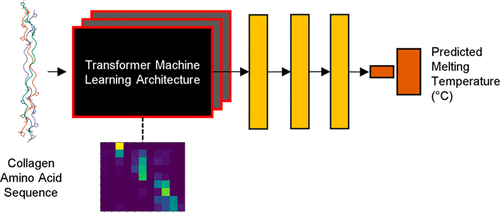 

In [2]:
import numpy as np
import pandas as pd
import os,sys
import math

import matplotlib.pyplot as plt
import tqdm

import cv2
import PIL 
from PIL import Image, ImageOps

import pickle
import torchvision.utils as vutils
import torch
 
import torchvision
 
import matplotlib.pyplot as plt
import numpy as np
 
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR

print("Torch version:", torch.__version__) 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from einops import rearrange, repeat

import seaborn as sns

Torch version: 2.0.0+cu117


In [37]:
LARGENUMBER=99999999999999

In [ ]:
from transformers import BertModel, BertTokenizer
import re
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")
tokenizer.save_pretrained("./PROTBERT_tokenizer")
tokenizer = BertTokenizer.from_pretrained("PROTBERT_tokenizer", do_lower_case=False )
namesve='PROTBERT_pretrained.pth'
torch.save(model, namesve)

In [4]:
from math import pi, log
import time
import seaborn as sns
from sklearn.metrics import r2_score

from sklearn.preprocessing import QuantileTransformer

from sklearn.preprocessing import RobustScaler

In [5]:
#CPUonly=True
CPUonly=False

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

if CPUonly == True:
     print ("CPU!")
     device = torch.device("cpu")

In [6]:
from torch.utils.data import DataLoader,Dataset
from torchvision.io import read_image
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image

to_pil = transforms.ToPILImage()

In [7]:
!nvidia-smi 

Wed Apr  5 18:30:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 517.89       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     On   | 00000000:01:00.0 Off |                  N/A |
| N/A   60C    P8     8W /  N/A |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
batch_size_=12

min_length = 0
max_length = 64

output_dim =1
 
query_dim=max_length

prefix = './BERT_finetune/'

if not os.path.exists(prefix):
        os.mkdir (prefix)
        
lossfile=prefix+'/lossfile.txt'  

In [12]:
#If set to True, TRAINING done
do_train=True

In [13]:
from transformers import BertModel, BertTokenizer

In [14]:
# LOAD BERT TOKENIZER
BERT_tokenizer = BertTokenizer.from_pretrained("PROTBERT_tokenizer", do_lower_case=False )

In [15]:
namesve='PROTBERT_pretrained.pth'

pretrained=torch.load(namesve).to(device)

In [16]:
pytorch_total_params = sum(p.numel() for p in pretrained.parameters())
pytorch_total_params_trainable = sum(p.numel() for p in pretrained.parameters() if p.requires_grad)

print ("Total parameters: ", pytorch_total_params," trainable parameters: ", pytorch_total_params_trainable)

Total parameters:  419931136  trainable parameters:  419931136


In [55]:
embed_dim_position = 8  # for position encoding
embed_dim_conv=128  #for conv
kernel_siz = 3
num_outputs = 1

class MyTotal_pos(nn.Module):
    def __init__(self , pretrained, transformertype=0, pretrained_trainable=True,  ):
        super(MyTotal_pos, self).__init__()
        
        self.pretrained = pretrained
        self.transformertype=transformertype
        
        if pretrained_trainable==False:
            for param in pretrained.parameters():
                param.requires_grad = False
                
        embed_dim_data=1024 

        depth_total= embed_dim_data
        
        self.mSig = nn.Sigmoid()
        
        self.pos_emb_x = nn.Embedding(max_length, embed_dim_position*1)
        
        self.fc1 = nn.Linear( max_length,  1)  # INPUT DIM (last), OUTPUT DIM, last
        self.fc2 = nn.Linear( max_length,  1)  # INPUT DIM (last), OUTPUT DIM, last
        self.fc3 = nn.Linear( max_length,  1)  # INPUT DIM (last), OUTPUT DIM, last
        
        self.BatchNorm_1 = nn.BatchNorm1d(max_length)
        self.fc_last = nn.Linear( depth_total,  1)  
        self.fc_last_2 = nn.Linear( max_length,  1)  
        
        self.transformertype=transformertype
            
        if transformertype==10: #REGULAR LINEAR
            print ("Linear head  selected....")
            nconv=0
            self.queries_dim_ = embed_dim_data   + nconv*embed_dim_conv #* same as input dim....
        
            self.fc_last = nn.Linear( depth_total,  num_outputs)  
            #
            self.fc_last_2 = nn.Linear( max_length,  num_outputs)  
             
        if transformertype==11: #Conv head 
            
            print ("Conv head selected....")
            self.embed_dim_conv = 512
            self.kernel_siz = kernel_siz
            self.queries_dim_ = embed_dim_data   + embed_dim_conv #* same as input dim....
            self.convs=nn.Sequential( nn.Conv1d(in_channels=depth_total, out_channels=self.embed_dim_conv, \
                                            kernel_size=self.kernel_siz, stride=1, \
                                            padding='same'),
                                            nn.Conv1d(in_channels=self.embed_dim_conv, out_channels=self.embed_dim_conv, \
                                            kernel_size=self.kernel_siz*1, stride=1, \
                                            padding='same'),
                                            nn.Conv1d(in_channels=self.embed_dim_conv, out_channels=int(self.embed_dim_conv), \
                                            kernel_size=self.kernel_siz, stride=1, \
                                            padding='same'),
                                            )
                                 
            self.fc_last = nn.Linear( int(self.embed_dim_conv/1),  num_outputs)  
           
            self.fc_last_2 = nn.Linear( max_length,  num_outputs)  
            
    def forward(self, x, mask=None):
           
        x_BERT = self.pretrained(**x )[0]
        
        x = torch.zeros(x_BERT.shape[0], max_length, x_BERT.shape[2]).to(device=device)
        x[:, :x_BERT.shape[1], :] = x_BERT
        
        if self.transformertype==11: 
             
            x=torch.permute(x, (0,2,1)  )
            x2=self.convs(x)
            x2=torch.permute(x2, (0,2,1)  )
             
            x2=self.fc_last(x2)
             
            x2=torch.permute(x2, (0,2,1)  )
            x2=self.fc_last_2 (x2) 
          
            
        return x2
 
model = DeepProteinModel( pretrained=pretrained, transformertype=11 ,pretrained_trainable=True, )

Conv head selected....


In [39]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print ("Total parameters: ", pytorch_total_params," trainable parameters: ", pytorch_total_params_trainable)

Total parameters:  423079813  trainable parameters:  3148677


In [40]:
import pytorch_warmup as warmup

criterion =  nn.MSELoss()

optimizer = optim.Adam(model.parameters() , lr=0.000005,  betas=(0.99, 0.999))

decayRate = 0.96

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decayRate)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period=500)
model.to(device)

DeepProteinModel(
  (pretrained): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-29): 30 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1

In [41]:
#test the input and output...
batch_sentences  = ["A A A C C C", "C A A ", "A A A A A A A"]

encoded_input = BERT_tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt").to(device)
print (encoded_input)
output = model(encoded_input)
#print (seq)
print ("output shape: ", output.shape)


{'input_ids': tensor([[ 2,  6,  6,  6, 23, 23, 23,  3,  0],
        [ 2, 23,  6,  6,  3,  0,  0,  0,  0],
        [ 2,  6,  6,  6,  6,  6,  6,  6,  3]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
output shape:  torch.Size([3, 1, 1])


In [68]:
def gen_validation_regression (model, test_loader, epoch=0, start_h=0,jointplott=False):
    
    pred=[]
    groundtruth=[]
     
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        steps=0
        
        print ("Number of batches: ", len (test_loader))
        for X_val_batch, y_val_batch in test_loader:
            
            if steps % print_every == 0:
                print("#", end="")
            
            X_val_batch = BERT_tokenizer(X_val_batch, padding=True, truncation=True, \
                                           return_tensors="pt")

            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(2))
          
            val_epoch_loss += val_loss.item()
            
            steps=steps+1
            
            for ibat in range (y_val_pred.shape[0] ):
                pred.append (np.array(torch.squeeze(y_val_pred[ibat,:].cpu() )  ) )
                groundtruth.append (np.array(torch.squeeze(y_val_batch[ibat,:].cpu() )  ))
            
    test_losses_local =val_epoch_loss/len(test_loader)
    
    print ("Number of datapoints: ", len(pred), len (groundtruth))
    pred_np = np.array(pred)
    groundtruth_np = np.array(groundtruth)
   
    sns.regplot( x=groundtruth_np[:], y=pred_np[:],scatter_kws={'s': 3} )
    
    outname = prefix+ f"./test_REG1-{running_loss/print_every:.6f}_epoch-{epoch+start_h}.svg"
    plt.savefig(outname, dpi=200)
    plt.show()
    
    if jointplott==True:
        sns.jointplot(x=groundtruth_np[:], y=pred_np[:],   kind="reg");
            
    R2_0=0
    R2_1=0
    R2_2=0
    R2_0=r2_score(groundtruth_np[:],pred_np[:])

    print ("R2 value: ", R2_0) 
    
    return pred_np, groundtruth_np, test_losses_local, R2_0, R2_1, R2_2, pred_np, groundtruth_np 
          
def trainepochs_regression (epochs=100, start_ep=0, lossfile='loss.txt', val_every=5):
    
    lowloss=LARGENUMBER
    savepath = prefix
    R1max=0
    R2max=0
    R3max=0
     
    for e in range(1, epochs+1):
        torch.cuda.empty_cache()
        print ("-----------------------------------------------")
        start = time.time()
        print ("Regression epoch: ", e+start_ep)
        
        train_epoch_loss = 0
        model.train()
        steps=0
        print ("Loop over ", len(train_loader), " batches (print . every ", print_every, " steps)")
        
        for X_train_batch, y_train_batch in train_loader:

            
            lr_scheduler.step(e+start_ep-1)
            warmup_scheduler.dampen()
             
            X_train_batch = BERT_tokenizer(X_train_batch, padding=True, truncation=True, \
                                           return_tensors="pt")
        
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)   

            optimizer.zero_grad()

            y_train_pred = model(X_train_batch)
            y_train_batch=y_train_batch.unsqueeze(2)
            
            train_loss = criterion(y_train_pred, y_train_batch )
            

            train_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    
            optimizer.step()

            train_epoch_loss += train_loss.item()

            if steps % print_every == 0:
                print(".", end="")
                
            steps=steps+1

        if e%val_every==0:
            
            print ("\nValidation: ")

            R1=0
            R2=0
            R3=0

            pred, groundtruth, test_losses_local, R1, R2, R3, _ , _ = gen_validation_regression (model, test_loader, epoch=e, \
                                                                               start_h=start_ep,jointplott=False)
            test_losses.append(test_losses_local)
            savefl=False
            if R1>R1max:
                 
                savefl=True
                print ("Found better R2...", R1, R1max)
                
            R1max=max(R1, R1max)
            R2max=max(R2, R2max)
            R3max=max(R3, R3max)
            
            print ("R2 values: ", R1, "R1 max: ", R1max)

            train_losses.append(train_epoch_loss/len(train_loader))
            print ("\n")

            plt.plot(train_losses, label='Training loss')
            plt.plot(test_losses, label='Validation loss')
            plt.legend(loc="upper right")
           
            outname = prefix+ f"./lossdata-{train_epoch_loss/len(train_loader):.6f}_epoch-{e+start_ep}.svg"
            plt.savefig(outname, dpi=200)
            plt.show()

            R1max_list.append(R1max)
            R1_list.append(R1)
            R2max_list.append(R2max)
            R2_list.append(R2)
            R3max_list.append(R3max)
            R3_list.append(R3)

            plt.plot(R1max_list, label='R2_1 max')
            plt.plot(R1_list,'.', label='R2_1')
            
            plt.ylim([0, 1.1])
            plt.legend(loc="lower right")
             
            outname = prefix+ f"./R2data-{train_epoch_loss/len(train_loader):.6f}_epoch-{e+start_ep}.svg"
            plt.savefig(outname, dpi=200)
            plt.show()

            if test_losses_local<lowloss or savefl:
            
              lowloss= test_losses_local
               
              namesve=savepath+'./model_IO_REGRESS_%4.4d.pth'%(e+start_ep)
               
              print ("Lower loss found. Save model as: ", namesve, " lowest testing loss: ", lowloss)
              torch.save(model, namesve)
            
            print ('Time taken for epoch {} is {} minutes\n'.format(e+start_ep,   (time.time()-start)/60) )
            print(f'Epoch {e+start_ep+0:04}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Test Loss: {test_losses_local:.5f} | Current lowest loss: {lowloss}')

            my_file = open(lossfile, "a+")
            my_file.write(str (e+start_ep) + ", " +  str (train_epoch_loss/len(train_loader)) +\
                          ", " + str (test_losses_local) + ', '+str(R1)+', '+str(R2)+', '+str(R3)+\
                          ', '+str(R1max)+', '+str(R2max)+', '+str(R3max)+'\n')
            my_file.close()
        
    return epochs + start_ep + 1

In [43]:
batch_sentences  = ["A A A C C C", "C A A "]

encoded_input = BERT_tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt")

output = pretrained(**encoded_input.to(device))

print (output[0].shape)
print (output[1].shape)

torch.Size([2, 8, 1024])
torch.Size([2, 1024])


In [46]:
class RegressionDataset(Dataset):

        def __init__(self, X_data, y_data):
            self.X_data = X_data
            self.y_data = y_data

        def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]

        def __len__ (self):
            return len(self.X_data)
        
def load_data_set_collagen (file_path ,   \
                   min_length=0, max_length=100, batch_size_=4, output_dim=1,  maxdata=9999999999999,\
                  quantile_scale=False, qt=None, split =0.2,scalertype=0):

    protein_df=pd.read_csv(file_path)
    protein_df

    protein_df.describe()
     
    df_isnull = pd.DataFrame(round((protein_df.isnull().sum().sort_values(ascending=False)/protein_df.shape[0])*100,1)).reset_index()
    df_isnull.columns = ['Columns', '% of Missing Data']
    df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
    cm = sns.light_palette("skyblue", as_cmap=True)
    df_isnull = df_isnull.style.background_gradient(cmap=cm)
    df_isnull
     
    
    #INPUT - X
    seqs = protein_df.Sequences.values
    test_seqs = seqs[:1]
    
    lengths = [len(s) for s in seqs]
   
    print(protein_df.head(6))
    protein_df=protein_df.reset_index(drop=True)

    min_length_measured =   min (lengths)
    max_length_measured =   max (lengths)

    fig_handle = sns.distplot(lengths,bins=50,kde=False, rug=False,norm_hist=False,axlabel='Length')
    fig = fig_handle.get_figure()
    plt.show()

    print ("Number of outputs: ", output_dim)
    if output_dim==1:
        y_data=protein_df[[ 'Tmelt']].to_numpy()
        fig_handle = sns.distplot(protein_df['Tmelt'],bins=50,kde=False, rug=False,norm_hist=False,axlabel='Collagen')
        fig = fig_handle.get_figure()
        plt.show()

    if quantile_scale==True:
        
        y_data=y_data 
        fig_handle = sns.distplot(y_data,bins=50,kde=False, rug=False,norm_hist=False,axlabel='Collagen Tm')
        fig = fig_handle.get_figure()
        plt.show()
        
        if qt:
            y_data=qt.transform(y_data)    
            print ("Use existing qt...")
        if qt==None:
            print ("Fit new qt...")
            if scalertype==0:
                print ("QuantileTransformer")
                qt = QuantileTransformer(n_quantiles=50, random_state=0)
            if scalertype==1:
                qt = RobustScaler()
                print ("RobustScaler")
            if scalertype==2:
                qt=MinMaxScaler()
                print ("MinMaxScaler")
            if scalertype==3:
                qt=StandardScaler()
                print ("StandardScaler")
            #data = trans.fit_transform(data)
            y_data=qt.fit_transform(y_data)

        print ("AFTER transform....")
        fig_handle = sns.distplot(y_data,bins=50,kde=False, rug=False,norm_hist=False,axlabel='Collagen Tm')
        fig = fig_handle.get_figure()
        plt.show()
        
        y_data_2=qt.inverse_transform(y_data)
        y_data_2=y_data_2  
        
        print ("AFTER REVERSAL transform....")
        fig_handle = sns.distplot(y_data_2,bins=50,kde=False, rug=False,norm_hist=False,axlabel='Collagen Tm')
        fig = fig_handle.get_figure()
        plt.show()        
    print ("AFTER SCALING: ", y_data.shape)
    
    # PREPARE SEQUENCES FOR BERT input
    X=[]
    for i in range  (len(seqs)):
    
        seqs[i]=seqs[i][0:max_length-2] # limit to max_length....
        temp=" ".join(seqs[i])
        X.append(temp) 
    
    print (X[0])
    
    if split == 1:
        print ("No splitting")
        train_dataset = RegressionDataset(X, torch.from_numpy(y_data).float())
        test_dataset = RegressionDataset(X, torch.from_numpy(y_data).float())
            
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=False)
         
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size_, shuffle=False)
        
        return train_loader, test_loader, min_length_measured, max_length_measured, qt
    
    if maxdata<y_data.shape[0]:
        
        rand_sel = np.random.choice(X.shape[0], maxdata, replace=False)
        X_se=X[rand_sel]
        y_data_se=y_data[rand_sel]
        X_train, X_test, y_train, y_test = train_test_split(X_se,  y_data_se , test_size=split,random_state=235)

    else:
        X_train, X_test, y_train, y_test = train_test_split(X,  y_data , test_size=split,random_state=235)

    train_dataset = RegressionDataset( X_train , torch.from_numpy(y_train).float())
    test_dataset = RegressionDataset( X_test , torch.from_numpy(y_test).float())

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size_)
     
    print ("Train sequences: ", len(train_loader)*batch_size_, "Test sequences: ", len(test_loader)*batch_size_)
    
    return train_loader, test_loader, min_length_measured, max_length_measured, qt

### Load data and train

In [ ]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
scalertype=3

train_loader, test_loader,min_length_measured, max_length_measured, qt \
= load_data_set_collagen (file_path='collagen_data.csv', \
                   min_length=min_length, max_length=max_length, batch_size_=batch_size_, output_dim=1,\
                   maxdata=9999999999, \
                 quantile_scale=True,qt=None,scalertype=scalertype)

In [48]:
lowestloss=LARGENUMBER
R1max =0
R1_list=[]
R1max_list =[]
R2max =0
R2_list=[]
R2max_list =[]
R3max =0
R3_list=[]
R3max_list =[]

epochs=10
print_every =100
train_losses, test_losses,val_acc = [], [], []

steps = 0
running_loss = 0.0
losshist=[]

In [49]:
val_every=1

In [ ]:
do_train = False
if do_train: 
    start_ep=trainepochs_regression (epochs=epochs, start_ep=0,    lossfile=lossfile, val_every=val_every)

### Now find model with highest R2 value and load

In [ ]:
if do_train:
    maxindex = np.argmax(R1_list)
    print(maxindex, len(R1_list))
    imax=(maxindex+1)*val_every
    print ("Epoch with best R2 value: ", imax)   
    name=f'./{prefix}/model_IO_REGRESS_{imax:04}.pth'
    print(name)

In [ ]:
do_train=False
if do_train==False:
    !wget https://www.dropbox.com/s/6w22yno9rpivtwj/model_IO_REGRESS_0040.pth?dl=0 -O model_IO_REGRESS_0040.pth


In [56]:
if do_train==False:
    name=f'model_IO_REGRESS_0040.pth'
    model = torch.load(name) 

Number of batches:  43
#Number of datapoints:  506 506


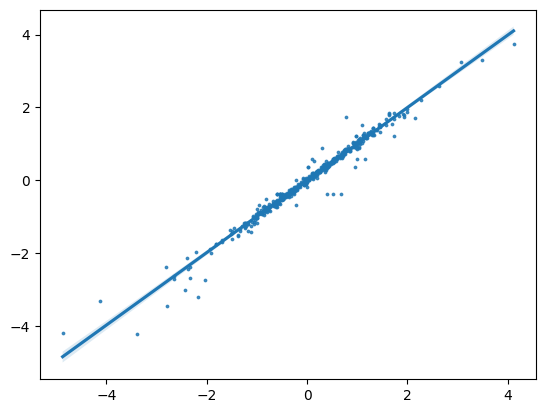

R2 value:  0.9719923055853839


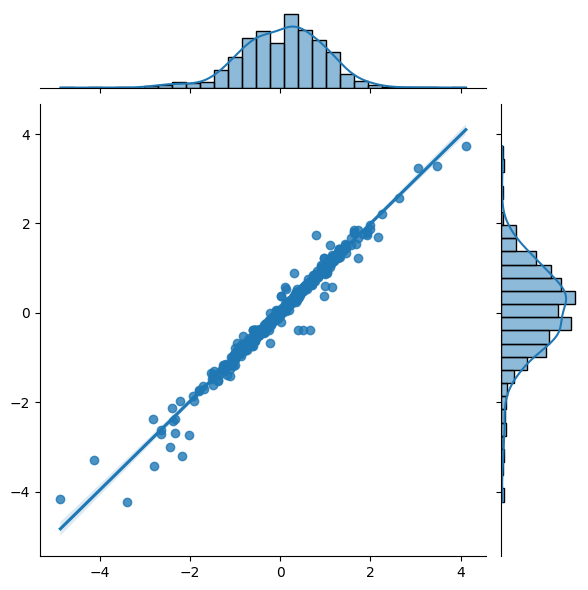

In [69]:
pred, groundtruth, test_losses_local, R1, R2, R3,  pred_np_train,groundtruth_np_train, = gen_validation_regression (model, train_loader, epoch=999, \
                                                                           start_h=999,jointplott=True
                                                                                      )


### General inference for a given sequence

In [60]:
def T_predictor(model,BERT_tokenizer,seqs,max_length, qt=None):
    model.eval()
    
    seqs=seqs[0:max_length-2] # limit to max_length - 2....
    temp=" ".join(seqs)
    
    X = BERT_tokenizer(temp, padding=True, truncation=True, \
                                           return_tensors="pt").to(device)
        
        
    prot_tm = model(X)
    
    
    if qt : #inverse scale if PRESENT
        temp_=prot_tm.cpu().detach().numpy() 
        temp_=np.squeeze(temp_, 2)
        #print(temp_.shape)
        prot_tm=qt.inverse_transform(temp_)
        
    prot_tm=np.squeeze(prot_tm)
    return prot_tm 


In [61]:
Tm=T_predictor (model, BERT_tokenizer, 'GPOGPOGPOGPOGPQGPGGPPGPOGPOGPOGPOGPO', max_length, qt)
print (Tm)

62.99669


In [62]:
Tm=T_predictor (model, BERT_tokenizer, 'GPOGPOGPODPOGPOGPOGPOGPO', max_length, qt)
print (Tm)

-2.4643276


## Various mutation cases and others

In [63]:
def predict_from_CSV (model,tokenizer,f='mut_pos_seq.csv',
                        f_out='mut_pos_seq_out.csv',
                        imagebase='correl1000',
                     ):
            #f='order_param_seq.csv'

    val_seqs=pd.read_csv(f)
    val_seqs

    val_seqs.describe()

    seqs = val_seqs.Sequences.values
    print (seqs[:6])    

    Tmlist=[]
    print ("Total sequences to be analyzed: ", len (seqs))
    for i in range (len (seqs)):
        seq=seqs[i]
        Tm=SS_predictor (model,  tokenizer, seq, max_length, qt)
        Tmlist.append(Tm)
        if i%10==0:
            print ('.',end="")

    plt.plot (Tmlist)
    plt.xlabel ('Sequence number')
    plt.ylabel ('$T_{m}$ in C')
    outname = prefix+ f"{imagebase}.svg"
    plt.savefig(outname, dpi=200)
    plt.show()

    val_seqs.insert(1, "Tm_predicted", Tmlist, True)

    val_seqs.to_csv(f_out)  
    
    return Tmlist

['GPOGPOGPOGPOGPOGPOGPOGPOGPOGPO' 'GAOGPOGPOGPOGPOGPOGPOGPOGPOGPO'
 'GPOGAOGPOGPOGPOGPOGPOGPOGPOGPO' 'GPOGPOGAOGPOGPOGPOGPOGPOGPOGPO'
 'GPOGPOGPOGAOGPOGPOGPOGPOGPOGPO' 'GPOGPOGPOGPOGAOGPOGPOGPOGPOGPO']
Total sequences to be analyzed:  660
..................................................................

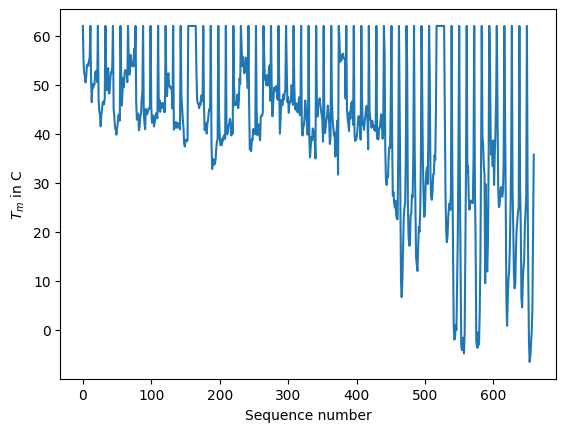

In [64]:
_=predict_from_CSV (model,BERT_tokenizer,f='mut_pos_seq.csv',
                        f_out='mut_pos_seq_out_ProtBERT.csv',
                        imagebase='correl1000',
                     )

['GPOGPOGPOGPOGPOGPOGPOGPOGPOGPO' 'GAOGPOGPOGPOGPOGPOGPOGPOGPOGPO'
 'GAOGAOGPOGPOGPOGPOGPOGPOGPOGPO' 'GAOGAOGAOGPOGPOGPOGPOGPOGPOGPO'
 'GAOGAOGAOGAOGPOGPOGPOGPOGPOGPO' 'GAOGAOGAOGAOGAOGPOGPOGPOGPOGPO']
Total sequences to be analyzed:  660
..................................................................

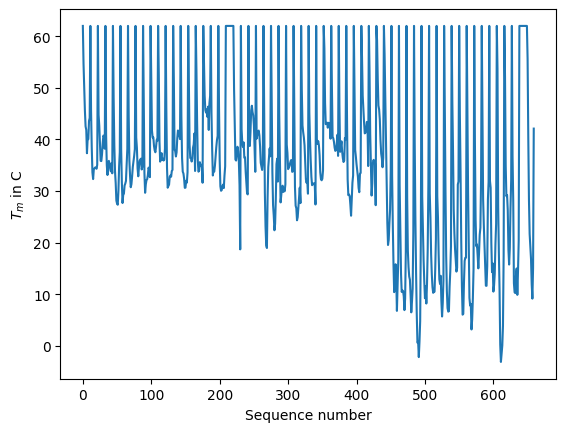

In [70]:
_=predict_from_CSV (model,BERT_tokenizer, f='order_param_seq.csv',
                        f_out='order_param_seq_out_ProtBERT.csv',
                        imagebase='correl1001',
                     )